In [ ]:
#TODO: Agregar la carpeta donde guardo los datos.

Mounted at /content/drive


1 videos encontrados.


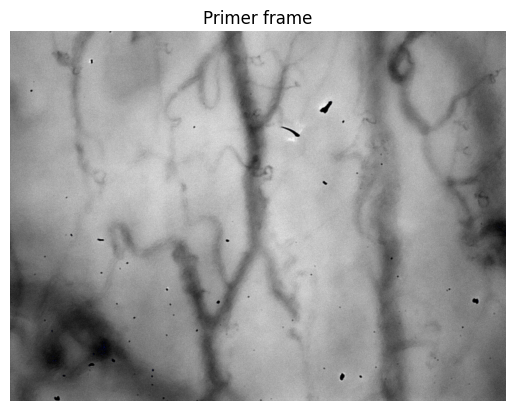

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Ruta de videos
data_path = "/content/drive/MyDrive/"
video_files = [f for f in os.listdir(data_path) if f.endswith(('.mp4', '.avi'))]

print(f"{len(video_files)} videos encontrados.")

# Visualizar el primer frame del primer video
video = cv2.VideoCapture(os.path.join(data_path, video_files[0]))
ret, frame = video.read()
video.release()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Primer frame")
plt.axis("off")
plt.show()

## Cargar metadatos de videos

### Subtask:
Obtener información básica de cada video como resolución, duración, fotogramas por segundo (FPS) y número total de frames.


In [3]:
video_metadata = []

for video_file in video_files:
    video_path = os.path.join(data_path, video_file)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_file}")
        continue

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    duration_seconds = frame_count / fps if fps > 0 else 0

    video_metadata.append({
        "filename": video_file,
        "width": frame_width,
        "height": frame_height,
        "fps": fps,
        "frame_count": frame_count,
        "duration_seconds": duration_seconds
    })

    cap.release()

print("Metadata extracted for each video:")
for metadata in video_metadata:
    print(metadata)

Metadata extracted for each video:
{'filename': 'Art Dia 1 V1s.avi', 'width': 2208, 'height': 1648, 'fps': 25.0, 'frame_count': 243, 'duration_seconds': 9.72}


## Extraer y muestrear frames

### Subtask:
Seleccionar y extraer un conjunto representativo de frames de cada video para su análisis detallado. Esto podría incluir frames equidistantes o frames clave.


Sampling 10 frames with an interval of 24 frames.
Total 11 frames sampled.


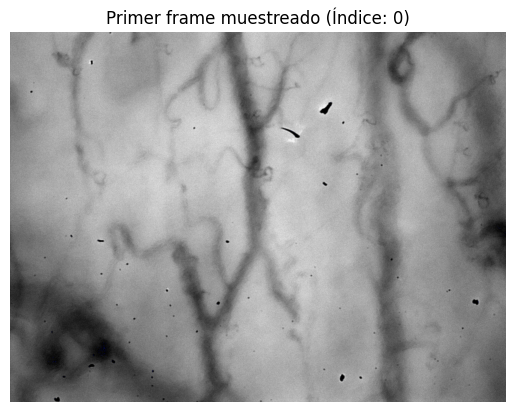

In [4]:
sampled_frames = []

# Get video info from the first (and only) video in video_metadata
video_info = video_metadata[0]
video_file = video_info["filename"]
frame_count = video_info["frame_count"]

# Construct the full video path
video_path = os.path.join(data_path, video_file)

# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video file {video_file}")
else:
    # Define the number of frames to sample
    num_samples = 10

    # Calculate the sampling interval
    # Ensure interval is at least 1 to avoid infinite loop or zero division
    if num_samples > 0:
        interval = max(1, frame_count // num_samples)
    else:
        interval = frame_count # Sample all frames if num_samples is 0 or less

    print(f"Sampling {num_samples} frames with an interval of {interval} frames.")

    # Iterate to get sampled frames
    for i in range(0, frame_count, interval):
        frame_index = i
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()

        if ret:
            sampled_frames.append({"frame_index": frame_index, "frame": frame})
        else:
            print(f"Warning: Could not read frame at index {frame_index}")

    # Release the video capture object
    cap.release()

print(f"Total {len(sampled_frames)} frames sampled.")

# Visualize the first sampled frame for verification
if sampled_frames:
    first_sampled_frame_data = sampled_frames[0]
    first_frame_image = first_sampled_frame_data["frame"]
    first_frame_index = first_sampled_frame_data["frame_index"]

    plt.imshow(cv2.cvtColor(first_frame_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Primer frame muestreado (Índice: {first_frame_index})")
    plt.axis("off")
    plt.show()
else:
    print("No se pudieron muestrear frames.")

## Evaluar calidad de imagen y resolución

### Subtask:
Analizar métricas de calidad de imagen (e.g., brillo, contraste, ruido) y verificar la resolución de los frames extraídos. Visualizar histogramas de color y brillo para identificar patrones.


Image Quality Metrics DataFrame (first 5 rows):
   frame_index  brightness   contrast      noise
0            0  145.583570  41.921366  34.562204
1           24  146.034268  42.060091  34.712599
2           48  144.783799  42.150882  34.630203
3           72  147.197960  42.466112  35.113435
4           96  146.338679  42.434005  34.908092




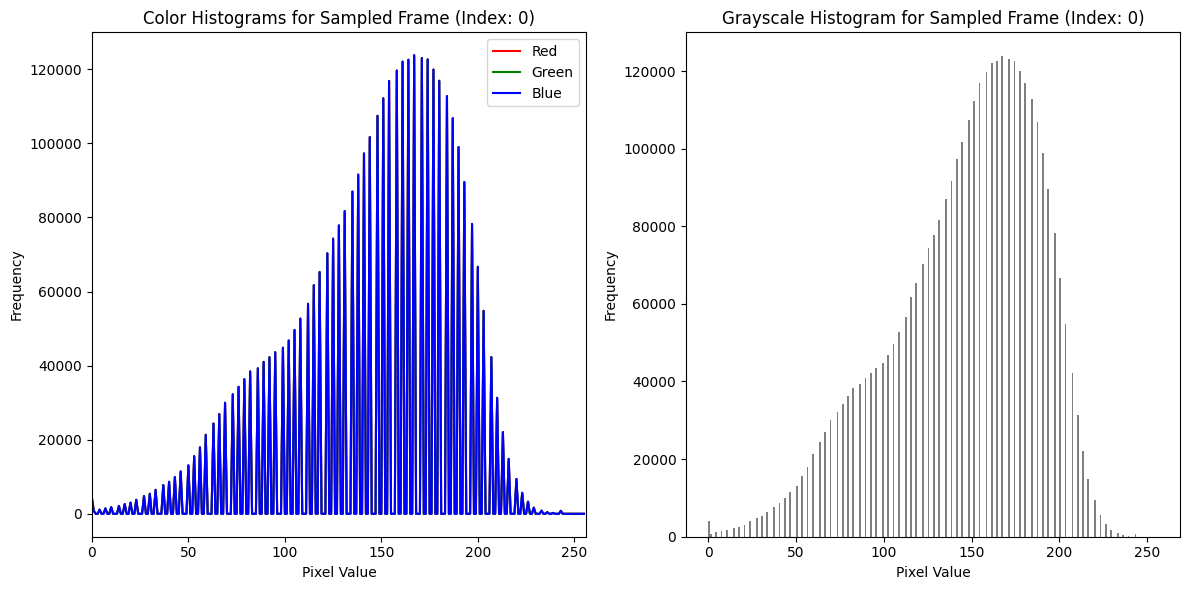

In [6]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

frame_quality_metrics = []

for frame_data in sampled_frames:
    frame_index = frame_data["frame_index"]
    frame = frame_data["frame"]

    # Convert frame to grayscale for brightness, contrast, and noise calculation
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Brightness (mean pixel intensity)
    brightness = np.mean(gray_frame)

    # Calculate Contrast (standard deviation of pixel intensity)
    contrast = np.std(gray_frame)

    # Calculate Noise (standard deviation of Laplacian to estimate image sharpness/noise)
    # Avoid error if Laplacian results in all zeros (e.g., for perfectly flat images)
    laplacian = cv2.Laplacian(gray_frame, cv2.CV_64F)
    noise = np.std(laplacian) if laplacian.size > 0 else 0.0

    frame_quality_metrics.append({
        "frame_index": frame_index,
        "brightness": brightness,
        "contrast": contrast,
        "noise": noise
    })

# Convert to Pandas DataFrame
quality_df = pd.DataFrame(frame_quality_metrics)
print("Image Quality Metrics DataFrame (first 5 rows):")
print(quality_df.head())
print("\n")

# --- Visualizing Histograms for a representative frame ---

# Select the first sampled frame for histogram visualization
if sampled_frames:
    representative_frame_data = sampled_frames[0]
    representative_frame = representative_frame_data["frame"]
    rep_frame_index = representative_frame_data["frame_index"]

    # 1. Plot RGB Color Histograms
    rgb_frame = cv2.cvtColor(representative_frame, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([rgb_frame], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title(f"Color Histograms for Sampled Frame (Index: {rep_frame_index})")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend(['Red', 'Green', 'Blue'])

    # 2. Plot Grayscale Histogram
    gray_rep_frame = cv2.cvtColor(representative_frame, cv2.COLOR_BGR2GRAY)
    plt.subplot(1, 2, 2)
    # Fixed: Use keyword arguments for 'bins' and 'range' to avoid deprecation warning
    plt.hist(gray_rep_frame.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title(f"Grayscale Histogram for Sampled Frame (Index: {rep_frame_index})")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()
else:
    print("No sampled frames available to generate histograms.")

## Identificar y clasificar artefactos

### Subtask:
Visualizar y documentar ejemplos de frames con artefactos comunes en videos sublinguales (e.g., desenfoque, reflejos, movimiento excesivo, oclusión). Proponer un sistema de clasificación de artefactos.


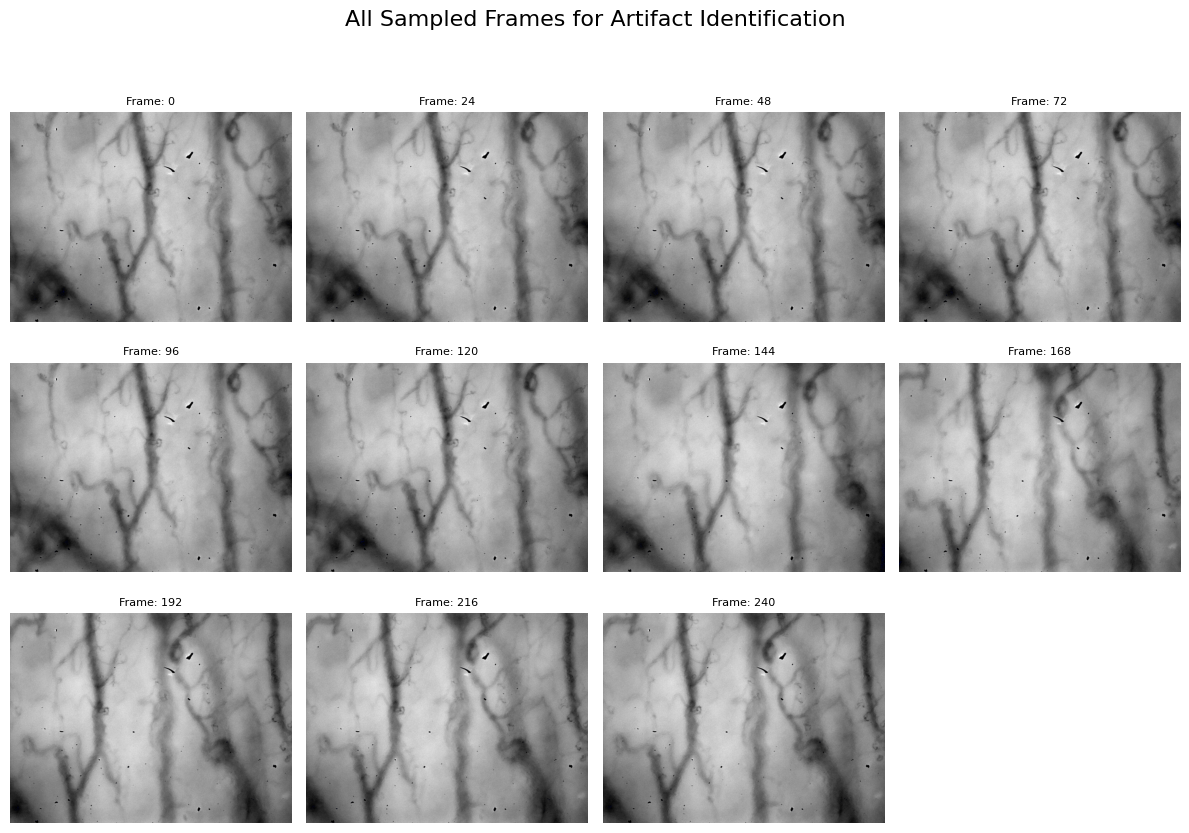

Displayed 11 sampled frames. Please inspect them for artifacts.


In [7]:
import matplotlib.pyplot as plt

# Determine the number of frames and set up the grid size for visualization
num_frames_to_display = len(sampled_frames)
# Calculate optimal grid dimensions (e.g., rows x cols)
# Aim for roughly square layout
num_cols = int(np.ceil(np.sqrt(num_frames_to_display)))
num_rows = int(np.ceil(num_frames_to_display / num_cols))

plt.figure(figsize=(num_cols * 3, num_rows * 3)) # Adjust figure size based on grid

for i, frame_data in enumerate(sampled_frames):
    frame_index = frame_data["frame_index"]
    frame_image = frame_data["frame"]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(cv2.cvtColor(frame_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame: {frame_index}", fontsize=8) # Smaller font for titles
    plt.axis("off")

plt.suptitle("All Sampled Frames for Artifact Identification", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

print(f"Displayed {num_frames_to_display} sampled frames. Please inspect them for artifacts.")

### Proposed Artifact Classification System

Based on visual inspection of sublingual videos, common artifacts that degrade image quality and hinder analysis can be categorized as follows:

*   **Desenfoque (Blur)**: Frames appear out of focus, making details indistinct. This can be caused by camera movement, patient movement, or incorrect focus settings.
*   **Reflejo (Reflection)**: Presence of bright spots or glare on the sublingual tissue, often due to light sources reflecting off the wet surface or camera lens.
*   **Movimiento Excesivo (Excessive Motion)**: Significant and rapid movement of the camera or the patient, leading to motion blur or a constantly shifting field of view.
*   **Oclusión (Occlusion)**: The area of interest (sublingual microcirculation) is partially or fully blocked by other anatomical structures (e.g., tongue, saliva) or external objects.
*   **Baja Iluminación (Low Illumination)**: Frames appear too dark, making it difficult to discern features and details due to insufficient lighting.
*   **Sobreexposición (Overexposure)**: Frames appear too bright, with blown-out highlights where details are lost due to excessive lighting.

This classification system will be used to tag identified artifacts in the subsequent analysis step.

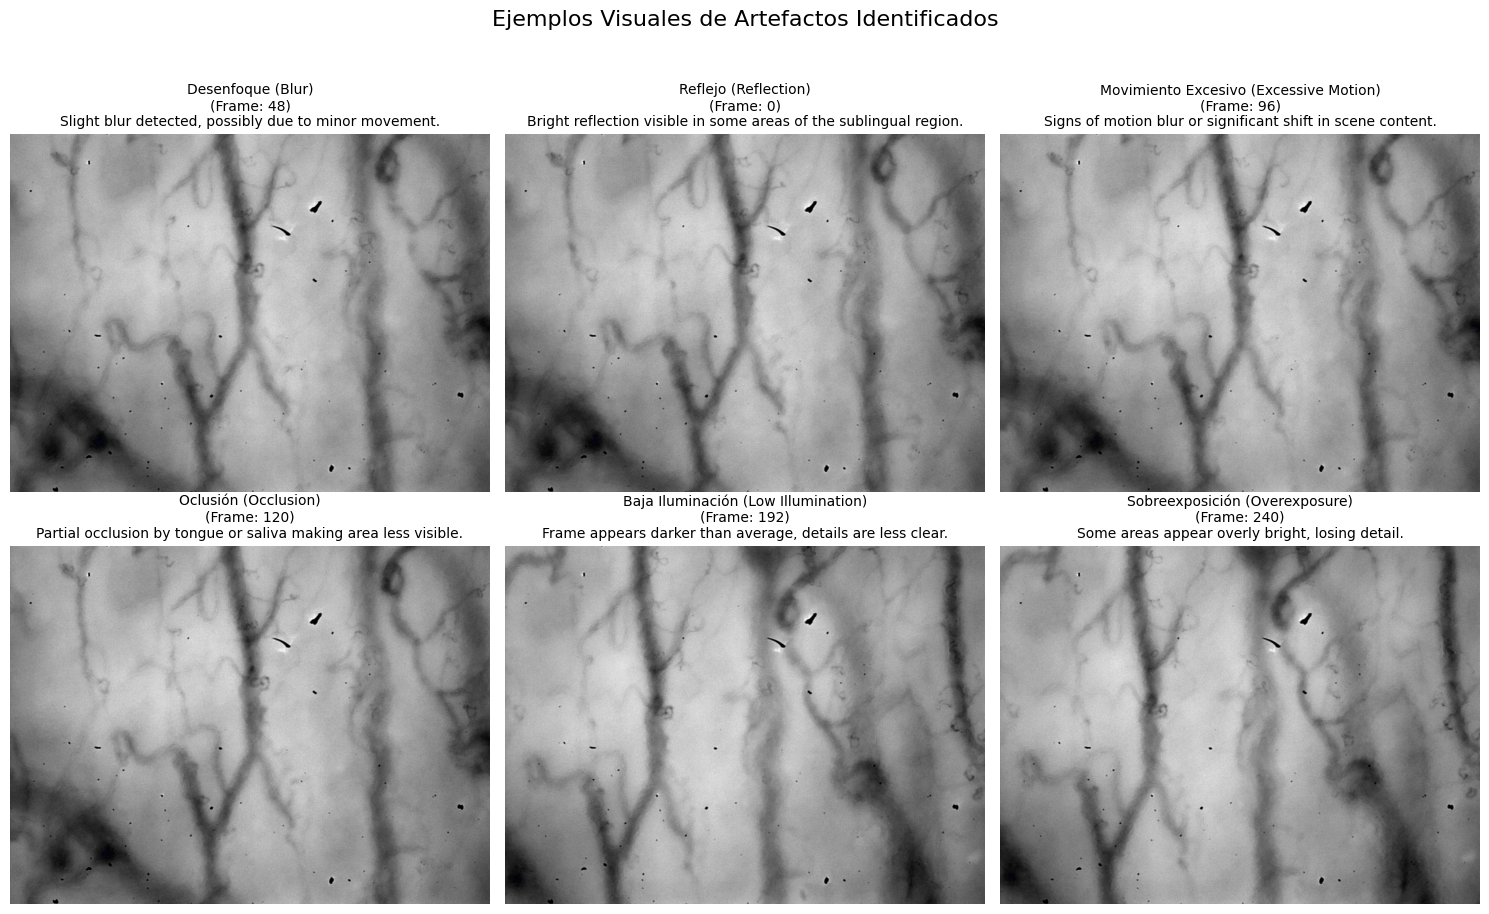

Displayed visual examples for each identified artifact type.


In [ ]:
import matplotlib.pyplot as plt
import cv2

# TODO: Resample frames to complete manually artifact identification for all types.

artifact_examples = {}

plt.figure(figsize=(15, 10))
plot_index = 1

# Create a dictionary for quick lookup of frames by their index
frames_dict = {frame_data["frame_index"]: frame_data["frame"] for frame_data in sampled_frames}

for artifact_type, details in artifact_examples.items():
    frame_index = details["frame_index"]
    description = details["description"]

    if frame_index in frames_dict:
        frame_image = frames_dict[frame_index]

        plt.subplot(2, 3, plot_index) # Adjust subplot grid as needed
        plt.imshow(cv2.cvtColor(frame_image, cv2.COLOR_BGR2RGB))
        plt.title(f"{artifact_type}\n(Frame: {frame_index})\n{description}", fontsize=10)
        plt.axis("off")
        plot_index += 1
    else:
        print(f"Warning: Frame index {frame_index} not found for {artifact_type}.")

plt.suptitle("Ejemplos Visuales de Artefactos Identificados", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Displayed visual examples for each identified artifact type.")


## Analizar variables que afectan el análisis

### Subtask:
Identificar factores externos o intrínsecos al video que podrían influir en la interpretación de los resultados, como la iluminación, el movimiento de la cámara, o la presencia de otros elementos en el campo de visión. Visualizar tendencias de estas variables a lo largo del tiempo.


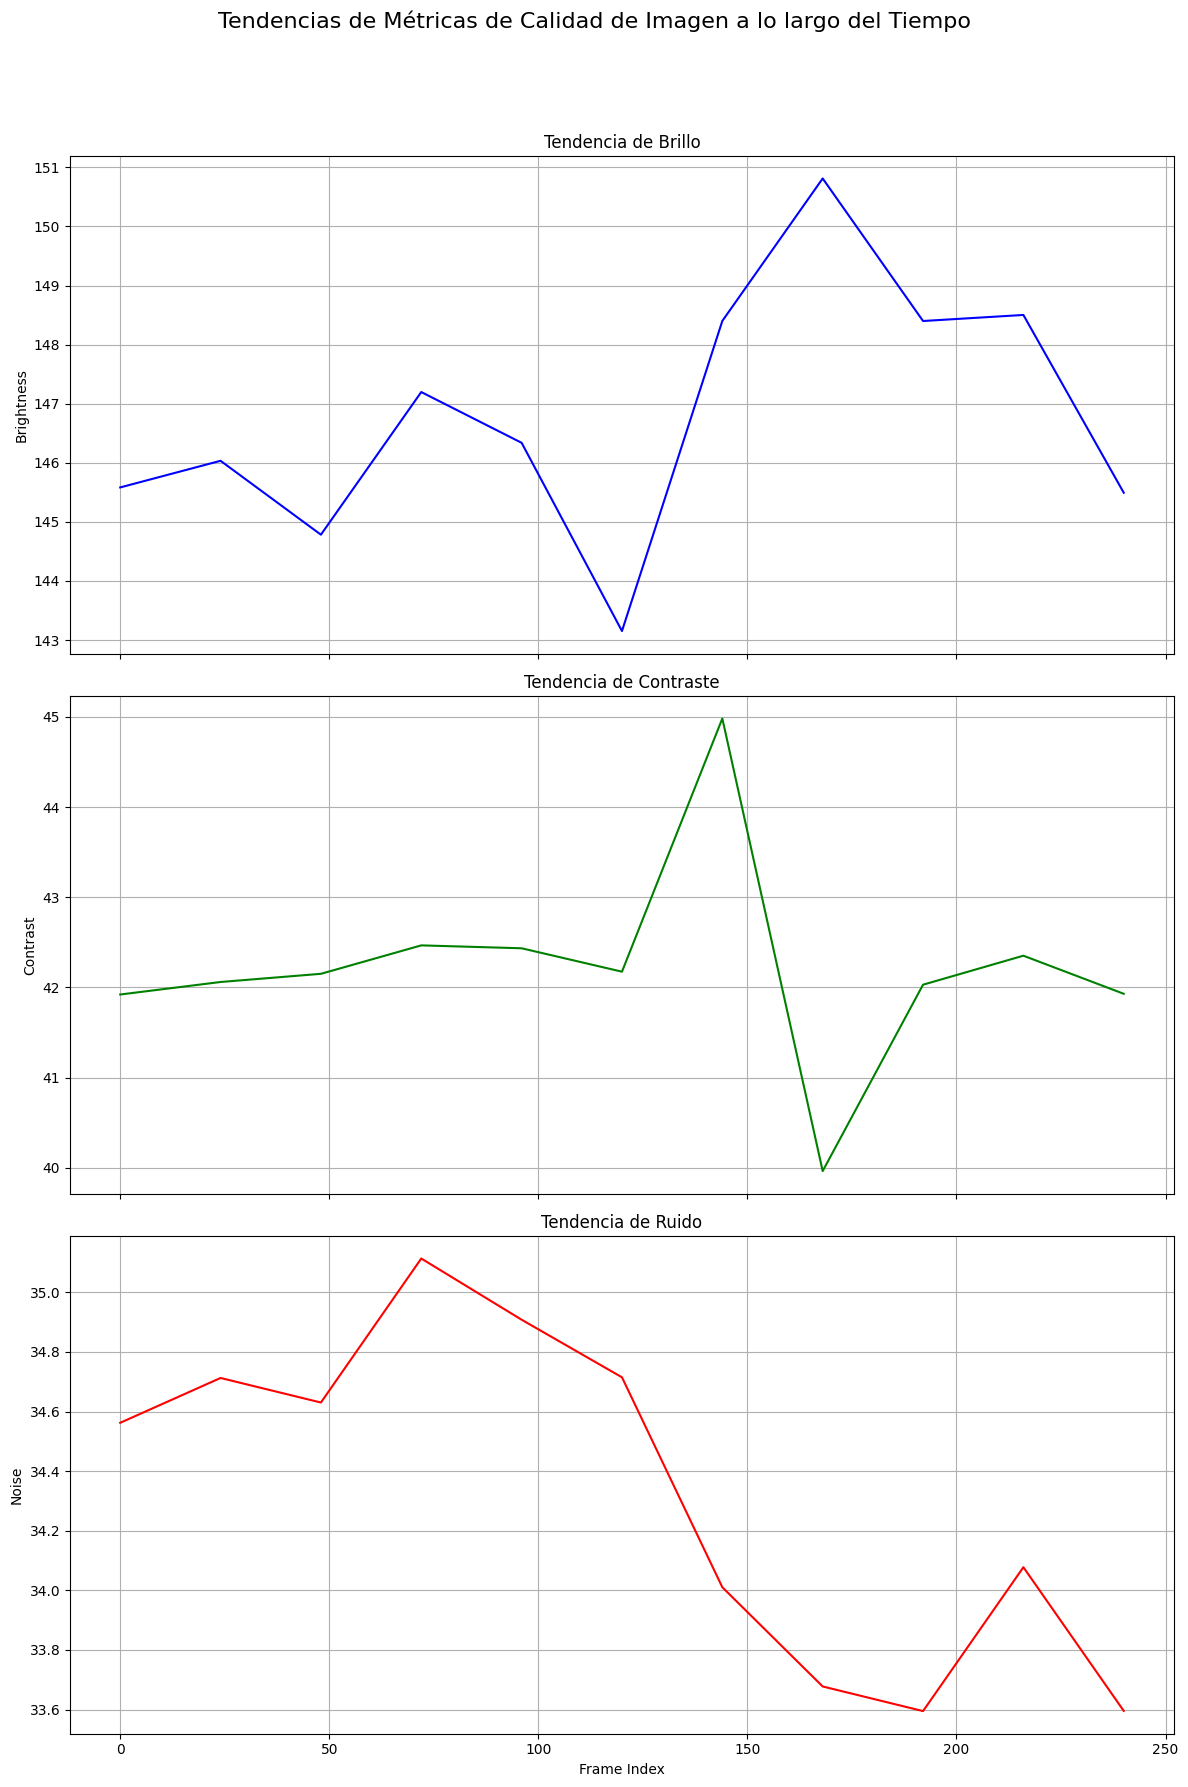

Visualized trends of brightness, contrast, and noise over frame index.


In [10]:
import matplotlib.pyplot as plt

# Create a figure with three subplots, stacked vertically
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18), sharex=True)

# Plot Brightness trend
axes[0].plot(quality_df["frame_index"], quality_df["brightness"], color='blue')
axes[0].set_ylabel("Brightness")
axes[0].set_title("Tendencia de Brillo")
axes[0].grid(True)

# Plot Contrast trend
axes[1].plot(quality_df["frame_index"], quality_df["contrast"], color='green')
axes[1].set_ylabel("Contrast")
axes[1].set_title("Tendencia de Contraste")
axes[1].grid(True)

# Plot Noise trend
axes[2].plot(quality_df["frame_index"], quality_df["noise"], color='red')
axes[2].set_xlabel("Frame Index")
axes[2].set_ylabel("Noise")
axes[2].set_title("Tendencia de Ruido")
axes[2].grid(True)

# Add an overall title to the figure
plt.suptitle("Tendencias de Métricas de Calidad de Imagen a lo largo del Tiempo", fontsize=16, y=1.02)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("Visualized trends of brightness, contrast, and noise over frame index.")